In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import AJA as aja
from torch_geometric.loader import DataLoader

In [16]:
df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

In [17]:
df_train_nodes.head()

,transcription,line,speaker_int,speaker_text,text,label,bert_0,bert_1,bert_2,bert_3,...,bert_374,bert_375,bert_376,bert_377,bert_378,bert_379,bert_380,bert_381,bert_382,bert_383
0,ES2002a,0,0,PM,Okay,0,-0.057809,-0.085828,-0.035720,-0.011185,...,0.018063,-0.033183,-0.004249,-0.026428,0.074381,0.010209,0.085386,-0.014607,0.058432,-0.009739
1,ES2002a,1,0,PM,Right,0,-0.054862,0.047607,-0.032626,-0.010949,...,0.092259,0.034839,-0.021490,0.007297,0.027587,0.027128,0.145950,0.037911,0.073511,0.079932
2,ES2002a,2,0,PM,<vocalsound> Um well this is the kick-off meet...,1,-0.054665,-0.073837,-0.017161,-0.064276,...,0.035382,0.098955,-0.025984,0.077994,0.003580,0.032260,0.022304,0.059096,-0.036019,-0.008820
3,ES2002a,3,0,PM,Um <vocalsound> and um,0,-0.010416,-0.072719,-0.017206,-0.088992,...,0.006533,0.032185,0.010955,0.041298,-0.018026,0.050856,0.007696,0.041694,0.077368,-0.037393
4,ES2002a,4,0,PM,this is just what we're gonna be doing over th...,0,-0.028654,-0.015151,0.095910,-0.059113,...,0.108833,0.061266,-0.011521,-0.010543,0.010692,0.117780,-0.017561,-0.028903,0.007401,-0.005552


In [ ]:
def f(x):
    #
    #
    return x

# train_graphs, validation_graphs, test_graphs = aja.get_graphs(f,f,0.2)

In [2]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs()

In [11]:
class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.channels = channels
        self.sc1 = 40
        self.f1 = 50
        self.sc2 = 30
        self.GCN1 = nn.ModuleList([GCNConv(input_dim, self.sc1) for _ in range(channels)])
        self.dense1 = nn.Linear(self.sc1*channels, self.f1)
        self.GCN2 = nn.ModuleList([GCNConv(self.f1, self.sc2) for _ in range(channels)])
        self.dense2 = nn.Linear(self.sc2*channels, 2)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        # Appliquez les couches GCN avec une activation ReLU entre elles
        x1 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc1)
            else:
                x = F.relu(self.GCN1[k](nodes, edges[k]))
            x1.append(x)
        x1_f = torch.cat(x1, dim=1)

        f1 = F.relu(self.dense1(x1_f))

        x2 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc2)
            else:
                x = F.relu(self.GCN2[k](f1, edges[k]))
            x1.append(x)
            x2.append(x)
        x2_f = torch.cat(x2, dim=1)

        x_out = self.dense2(x2_f)

        return F.log_softmax(x_out, dim=1)

In [12]:
# Instanciez le modèle
model = NodeClassifier(16,386)

# Définissez la fonction de perte et l'optimiseur
f = 0.3
#criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1-f, f]))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
train_graphs

{'IS1003a': Data(x=[358, 386], edge_index=[16], y=[358]),
 'TS3012b': Data(x=[1487, 386], edge_index=[16], y=[1487]),
 'TS3008d': Data(x=[1328, 386], edge_index=[16], y=[1328]),
 'ES2007b': Data(x=[547, 386], edge_index=[16], y=[547]),
 'IS1003d': Data(x=[1095, 386], edge_index=[16], y=[1095]),
 'TS3010c': Data(x=[689, 386], edge_index=[16], y=[689]),
 'IS1001c': Data(x=[515, 386], edge_index=[16], y=[515]),
 'IS1001d': Data(x=[379, 386], edge_index=[16], y=[379]),
 'IS1001a': Data(x=[254, 386], edge_index=[16], y=[254]),
 'IS1004c': Data(x=[839, 386], edge_index=[16], y=[839]),
 'TS3011c': Data(x=[1017, 386], edge_index=[16], y=[1017]),
 'TS3008a': Data(x=[471, 386], edge_index=[16], y=[471]),
 'TS3012a': Data(x=[373, 386], edge_index=[16], y=[373]),
 'TS3009a': Data(x=[714, 386], edge_index=[16], y=[714]),
 'TS3011b': Data(x=[985, 386], edge_index=[16], y=[985]),
 'ES2016a': Data(x=[481, 386], edge_index=[16], y=[481]),
 'IS1003c': Data(x=[869, 386], edge_index=[16], y=[869]),
 'IS10

Epoch: 000, Loss: 27.8756
F1-score: 0.0
Epoch: 001, Loss: 24.4358
F1-score: 0.5587000663552101
Epoch: 002, Loss: 24.1032
F1-score: 0.012582869192599638
Epoch: 003, Loss: 23.8246
F1-score: 0.0
Epoch: 004, Loss: 23.0100
F1-score: 0.5573172055508524
-------------------------
Analyse des performance du modèle :
-------------------------
F1-score: 0.5573172055508524


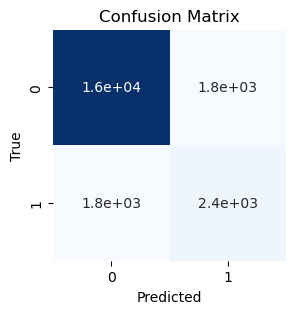

In [14]:
for epoch in range(5):
    loss = aja.train(model, train_graphs, optimizer, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    aja.test_during_training(model, validation_graphs)

aja.analyse_model(model, validation_graphs)

In [15]:
aja.make_test_csv_submission(model, test_graphs, 'test_pipeline')